In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [2]:
class MC_ES():
    
    def __init__(self, shape=(10, 10, 2, 2)):
        
        # q_value : 4d array,  state-action pairs
        # hand_sum * dealer_show * usable_ace * action(hit or stick) => 10 * 10 * 2 * 2
        self.q_values = np.zeros(shape)
        self.n_visits = np.copy(self.q_values)
        self.update_policy()
        self.reset()
        
    def update_policy(self):
        # policy : 3d array, boolean value (hit or stick) for each state
        # hand_sum * dealer_show * usable_ace => 10 * 10 * 2
        self.policy = np.argmax(self.q_values, axis=len(self.q_values.shape)-1)
    
    def action(self, state):
        # exploration start
        if self.start:
            self.start = False
            return np.random.choice([0,1])
        else:
            return self.policy[state]
    
    def learn(self, state_actions, returns):
        
        for (s, a), r in zip(state_actions, returns):
            
            index = *s,a
            self.n_visits[index] += 1
            #visits = self.n_visits[index]
            #self.q_values[index] = (visits-1)/visits * self.q_values[index] + 1/visits * r
            
            self.q_values[index] += (1/self.n_visits[index]) * (r - self.q_values[index])
            
        self.update_policy()
    
    def reset(self):
        self.start = True

In [3]:
def episode(env, agent, es=True):
    
    if es:
        agent.reset()
    else:
        agent.start = False
    state = env.reset()
    
    # hit immediately if sum < 11
    if state[0] < 11:
        state = env.step(True)[0]
    
    state_actions = []
    rewards = []
    
    # play a full game
    while (True):
        
        state = (
                 state[0]-12, # hand_sum, range 11-32 -> 0 - 21
                 state[1]-1,  # dealer_show, range 1-10 -> 0-9
                 int(state[2]) # usable ace, Bool -> 0 or 1
                )
        
        action = agent.action(state)
        state_actions.append((state, action))
        
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        # end episode
        if done:
            break
    
    return state_actions, rewards

In [4]:
EPISODES = 100000
GAMMA = 0.9
env = gym.make('Blackjack-v0')
agent = MC_ES()
mean_rewards = []

for i in range(EPISODES):
    
    state_actions, rewards = episode(env, agent)
            
    g = 0
    returns = []
    for reward in rewards[::-1]:                    # <- NOT COMPLETE to 1st state visit yet, but blackjack is one-way
        g = GAMMA * g + reward
        returns.insert(0, g)
    
    #print(state_actions)
    #print(returns)
    
    agent.learn(state_actions, returns)

    # test average reward, without random exploration
    if i % 100 == 0:
        rewards = [episode(env, agent, es=False)[1][-1] for _ in range(500)]
        mean_rewards.append(sum(rewards) / len(rewards))

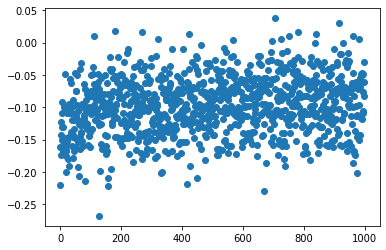

In [5]:
# plotting payoff vs. episodes trained

plt.scatter(range(len(mean_rewards)), mean_rewards);

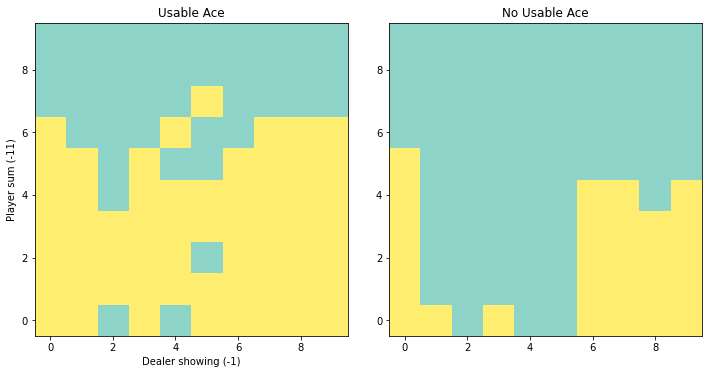

In [14]:
# plotting policy

fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.tight_layout()
axs[0].imshow(agent.policy[:11,:,1], cmap='Set3', origin='lower');
axs[0].set_title("Usable Ace");
axs[0].set_xlabel("Dealer showing (-1)");
axs[0].set_ylabel("Player sum (-11)");
axs[1].imshow(agent.policy[:11,:,0], cmap='Set3', origin='lower');
axs[1].set_title("No Usable Ace");

# => figure 5.2 in Sutton & Barto

In [15]:
agent.q_values

array([[[[-7.790e-01, -4.749e-01],
         [-7.692e-01, -3.705e-01]],

        [[-3.503e-01, -2.663e-01],
         [-1.200e-01,  9.405e-02]],

        [[-2.685e-01, -2.696e-01],
         [ 2.727e-01, -9.667e-02]],

        [[-1.931e-01, -1.660e-01],
         [ 0.000e+00,  2.275e-01]],

        [[-1.274e-01, -2.036e-01],
         [-1.250e-01, -2.809e-01]],

        [[-1.931e-01, -2.057e-01],
         [-3.043e-01, -1.843e-01]],

        [[-5.012e-01, -1.746e-01],
         [-2.593e-01,  9.045e-02]],

        [[-5.000e-01, -2.849e-01],
         [-3.846e-01,  2.076e-01]],

        [[-5.326e-01, -3.307e-01],
         [-4.783e-01,  6.600e-02]],

        [[-5.544e-01, -3.856e-01],
         [-5.281e-01, -9.264e-02]]],


       [[[-7.820e-01, -5.390e-01],
         [-7.308e-01, -3.203e-01]],

        [[-2.697e-01, -3.554e-01],
         [-3.182e-01, -1.726e-01]],

        [[-2.375e-01, -3.163e-01],
         [-1.200e-01,  5.362e-02]],

        [[-2.326e-01, -2.819e-01],
         [-2.000e-01,  9.75